In [1]:
import numpy as np
from scipy import linalg
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.collections
import matplotlib.patches
import pg_fitter_tools as fit
import sk_geo_tools as geo
import cv2
from collections import Counter

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
#%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [4]:
def get_led_positions(led_count, mpmt_locations):
    led_ring_radius = 24.
    led_positions = {}
    for k, v in mpmt_locations.items():
        for i in range(led_count):
            if abs(v[1]) > 100:
                led_positions[k+'-'+str(i)] = v+led_ring_radius*np.array([np.sin(i*2*np.pi/led_count),0,np.cos(i*2*np.pi/led_count)])
            else:
                phi = np.arctan2(v[2], v[0])
                led_positions[k+'-'+str(i)] = v+led_ring_radius*np.array([np.sin(i*2*np.pi/led_count)*np.sin(phi), np.cos(i*2*np.pi/led_count), -np.sin(i*2*np.pi/led_count)*np.cos(phi)])
    return led_positions

In [5]:
def get_image_feature_locations(feature_positions, camera_matrix, distortion, camera_rotations, camera_translations, image_size):
    image_feature_locations = {
        i : {list(feature_positions.keys())[f]:v for f, v in enumerate(cv2.projectPoints(np.array(list(feature_positions.values())), r, t, camera_matrix, distortion)[0].reshape((-1,2)))
             if v[0] > 0 and v[0] < image_size[0] and v[1] > 0 and v[1] < image_size[1]}
        for i, (r, t) in enumerate(zip(camera_rotations, camera_translations))}
    feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
    print("Feature in image counts:", Counter(feature_counts.values()))
    return image_feature_locations

In [6]:
def get_smeared_feature_locations(image_feature_locations, pixel_error, image_size):
    smeared_feature_locations = {}
    for k, i in image_feature_locations.items():
        smeared_feature_locations[k] = {}
        for j, f in i.items():
            smeared = np.random.normal(f, pixel_error)
            if(smeared[0] > 0 and smeared[0] < image_size[0] and smeared[1] > 0 and smeared[1] < image_size[1]):
                smeared_feature_locations[k][j] = smeared
    smeared_feature_counts = Counter([f for i in smeared_feature_locations.values() for f in i.keys()])
    print("Smeared feature in image counts:", Counter(smeared_feature_counts.values()))
    return smeared_feature_locations

In [7]:
def setup_led_simulation(feature_positions, image_feature_locations, focal_length, principle_point, radial_distortion, seed_error=1):
    seed_feature_positions = {}
    for i, f in feature_positions.items():
        seed_feature_positions[i] = np.random.normal(f, seed_error)
    fitter = fit.PhotogrammetryFitter(image_feature_locations, seed_feature_positions, focal_length, principle_point, radial_distortion)
    return fitter

In [8]:
def plot_images(image_feature_locations, image_size):
    for i in image_feature_locations.values():
        fig, ax = plt.subplots(figsize=(12,9))
        coords = np.rint(np.stack(list(i.values())))
        ax.scatter(coords[:,0], -coords[:,1], marker='s', s=0.2)
        ax.set_xlim((0, image_size[0]))
        ax.set_ylim((-image_size[1], 0))
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        fig.tight_layout()

In [9]:
def run_led_fit(fitter, led_positions):
    reco_cam_rotations, reco_cam_translations, reprojected_points = fitter.estimate_camera_poses()
    reco_cam_rotations, reco_cam_translations, reco_locations = fitter.bundle_adjustment(reco_cam_rotations, reco_cam_translations)
    
    reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_locations)
    print("mean reconstruction error:", linalg.norm(reco_errors, axis=1).mean())
    print("max reconstruction error:", linalg.norm(reco_errors, axis=1).max())

    reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(reco_cam_rotations, reco_cam_translations)
    cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
    cam_positions_translated = reco_cam_positions - translation
    cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

    reco_led_positions = reco_positions_dict(reco_transformed, fitter.feature_index)
    position_errors = linalg.norm(reco_errors, axis=1)

    return reco_led_positions, position_errors

In [10]:
def reco_positions_dict(reco_positions, feature_index):
    return {f: reco_positions[i] for f, i in feature_index.items()}

In [11]:
def get_mpmt_centre_errors(reco_led_positions, mpmt_positions, led_count):
    reco_mpmt_positions = {k: np.mean([reco_led_positions[k + "-" + str(b)] for b in range(led_count)], axis=0)
                           for k in mpmt_positions.keys()}
    errors = np.array([linalg.norm(reco_mpmt_positions[k] - mpmt_positions[k]) for k in mpmt_positions.keys()])
    return errors

In [12]:
def get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_coun):
    reco_orientations = {}
    for k in mpmt_orientations.keys():
        c, n = geo.fit_plane(np.array([reco_led_positions[k + "-" + str(b)] for b in range(led_count)]))
        # flip normal if it is directed away from tank centre
        if np.dot(n,c) > 0:
            n = -n
        reco_orientations[k] = n
    errors = np.array([np.degrees(np.arccos(np.dot(reco_orientations[k], mpmt_orientations[k]))) for k in mpmt_orientations.keys()])
    return errors

In [13]:
def make_fig(title=None, xlabel=None, ylabel=None, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    return fig, ax

In [14]:
def plot_geometry(led_positions, cam_positions):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter([l[0] for l in led_positions.values()], [l[2] for l in led_positions.values()], [l[1] for l in led_positions.values()], marker='*', label="LED", s=1)
    ax.scatter(cam_positions[:,0], cam_positions[:,2], cam_positions[:,1], marker='o', label="Camera", s=60)
    plt.legend(loc=0)
    fig.tight_layout()

In [15]:
def plot_reconstruction(reco_positions, cam_positions):
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(reco_positions[:,0], reco_positions[:,2], reco_positions[:,1], marker='*', label="LED", s=1)
    ax.scatter(cam_positions[:,0], cam_positions[:,2], cam_positions[:,1], marker='o', label="Camera", s=60)
    plt.legend(loc=0)
    fig.tight_layout()

In [16]:
pixel_errors = [1.0, 3.0, 5.0, 10.0]

In [17]:
pmt_locations = fit.read_3d_feature_locations("parameters/WCTE_16cShort_PMT_locations.txt", delimiter=" ")
#mpmt_locations = {k: v for k, v in pmt_locations.items() if int(k)%19==0}
mpmt_locations = fit.read_3d_feature_locations("parameters/WCTE_16cShort_centrePMT_locations.txt", delimiter=" ")
mpmt_orientations = {k: np.array((0,-1,0)) if v[1]>100
                     else np.array((0,1,0)) if v[1]<-100
                     else np.array((-v[0],0,-v[2]))/np.sqrt(v[0]**2+v[2]**2)
                     for k, v in mpmt_locations.items()}
led_count = 12
led_positions = get_led_positions(led_count, mpmt_locations)

In [18]:
mpmt_locations

{'19': array([160.01661746,  26.7375    ,  31.8292842 ]),
 '38': array([135.65553801,  26.7375    ,  90.64213261]),
 '57': array([ 90.64213261,  26.7375    , 135.65553801]),
 '76': array([ 31.8292842 ,  26.7375    , 160.01661746]),
 '95': array([-31.8292842 ,  26.7375    , 160.01661746]),
 '114': array([-90.64213261,  26.7375    , 135.65553801]),
 '133': array([-135.65553801,   26.7375    ,   90.64213261]),
 '152': array([-160.01661746,   26.7375    ,   31.8292842 ]),
 '171': array([-160.01661746,   26.7375    ,  -31.8292842 ]),
 '190': array([-135.65553801,   26.7375    ,  -90.64213261]),
 '209': array([ -90.64213261,   26.7375    , -135.65553801]),
 '228': array([ -31.8292842 ,   26.7375    , -160.01661746]),
 '247': array([  31.8292842 ,   26.7375    , -160.01661746]),
 '266': array([  90.64213261,   26.7375    , -135.65553801]),
 '285': array([135.65553801,  26.7375    , -90.64213261]),
 '304': array([160.01661746,  26.7375    , -31.8292842 ]),
 '323': array([160.01661746, -26.7375

In [19]:
mpmt_orientations

{'19': array([-0.98078528,  0.        , -0.19509032]),
 '38': array([-0.83146961,  0.        , -0.55557023]),
 '57': array([-0.55557023,  0.        , -0.83146961]),
 '76': array([-0.19509032,  0.        , -0.98078528]),
 '95': array([ 0.19509032,  0.        , -0.98078528]),
 '114': array([ 0.55557023,  0.        , -0.83146961]),
 '133': array([ 0.83146961,  0.        , -0.55557023]),
 '152': array([ 0.98078528,  0.        , -0.19509032]),
 '171': array([0.98078528, 0.        , 0.19509032]),
 '190': array([0.83146961, 0.        , 0.55557023]),
 '209': array([0.55557023, 0.        , 0.83146961]),
 '228': array([0.19509032, 0.        , 0.98078528]),
 '247': array([-0.19509032,  0.        ,  0.98078528]),
 '266': array([-0.55557023,  0.        ,  0.83146961]),
 '285': array([-0.83146961,  0.        ,  0.55557023]),
 '304': array([-0.98078528,  0.        ,  0.19509032]),
 '323': array([-0.98078528,  0.        , -0.19509032]),
 '342': array([-0.83146961,  0.        , -0.55557023]),
 '361': a

In [20]:
pixel_errors = [1.0, 3.0, 5.0, 10.0]

# Simulation with Sony a7R-IV

In [21]:
focal_length = np.array([3526.4, 3622.6])
principle_point = np.array([4719.6, 3240.2])
radial_distortion = np.array([-0.1981, 0.0361])
tangential_distortion = np.array([0, 0])
camera_matrix = fit.build_camera_matrix(focal_length, principle_point)
distortion = fit.build_distortion_array(radial_distortion, tangential_distortion)
image_size = np.array([9504, 6336])
image_area = [[0,image_size[0]],[0,image_size[1]]]

## 8 camera corner configuration

In [22]:
all_cam_positions = np.array([[97.47275687, 14.93703117, 99.94996814],
                              [29.15674544, 141.7448364, 147.4176074],
                              [44.82084089, 266.7725, -44.9380583],
                              [29.29952975, 16.2275, -28.97664714],
                              [-97.47275687 , 14.93703117, -99.94996814],
                              [99.94996814, 272.2629688, -97.47275687],
                              [99.94996814, 14.93703117, -97.47275687],
                              [-99.94996814, 14.93703117, 97.47275687],
                              [-29.15674544, 141.7448364, -147.4176074],
                              [-147.4176074, 141.7448364, 29.15674544],
                              [-99.94996814, 272.2629688, 97.47275687],
                              [97.47275687, 272.2629688, 99.94996814],
                              [147.4176074, 141.7448364, -29.15674544],
                              [-97.47275687, 272.2629688, -99.94996814]])
corner_cam_positions = all_cam_positions[(0,4,5,6,7,10,11,13),:]
cam_offsets = np.mean(corner_cam_positions, axis=0)
all_cam_positions = all_cam_positions - cam_offsets
corner_cam_positions = corner_cam_positions - cam_offsets

In [23]:
corner_cam_directions = [[-1, +1.9, -1],
                         [+1, +1.9, +1],
                         [-1, -1.9, +1],
                         [-1, +1.9, +1],
                         [+1, +1.9, -1],
                         [+1, -1.9, -1],
                         [-1, -1.9, -1],
                         [+1, -1.9, +1]]

In [24]:
camera_positions = corner_cam_positions
camera_directions = corner_cam_directions
camera_directions = camera_directions / linalg.norm(camera_directions, axis=1, keepdims=True)
camera_rolls = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])#[np.pi/2, np.pi/2, np.pi/2, np.pi/2])
camera_rotations, camera_translations = fit.camera_poses(camera_positions, camera_directions, camera_rolls)
camera_count = camera_positions.shape[0]
simulator = fit.PhotogrammetrySimulator(led_positions, focal_length, principle_point, camera_rotations, camera_translations, radial_distortion, tangential_distortion)

Total number of features:  1272
Number of features in more than one image:  1272
Feature in image counts: Counter({4: 504, 8: 344, 7: 212, 6: 152, 5: 60})


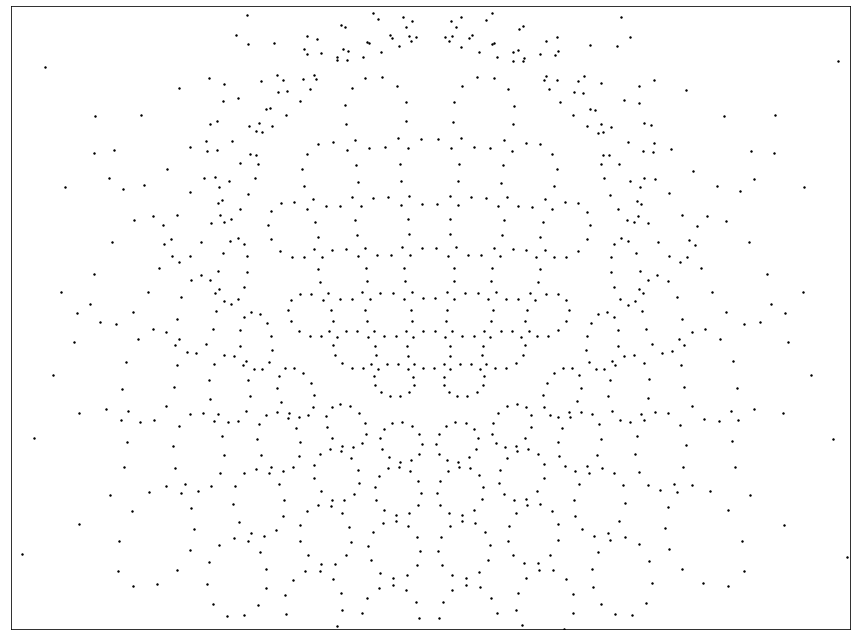

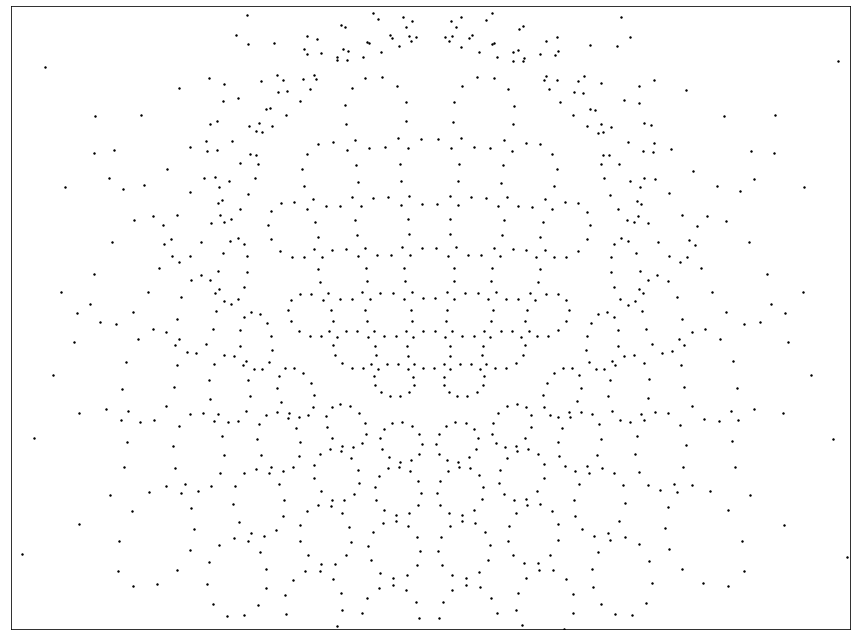

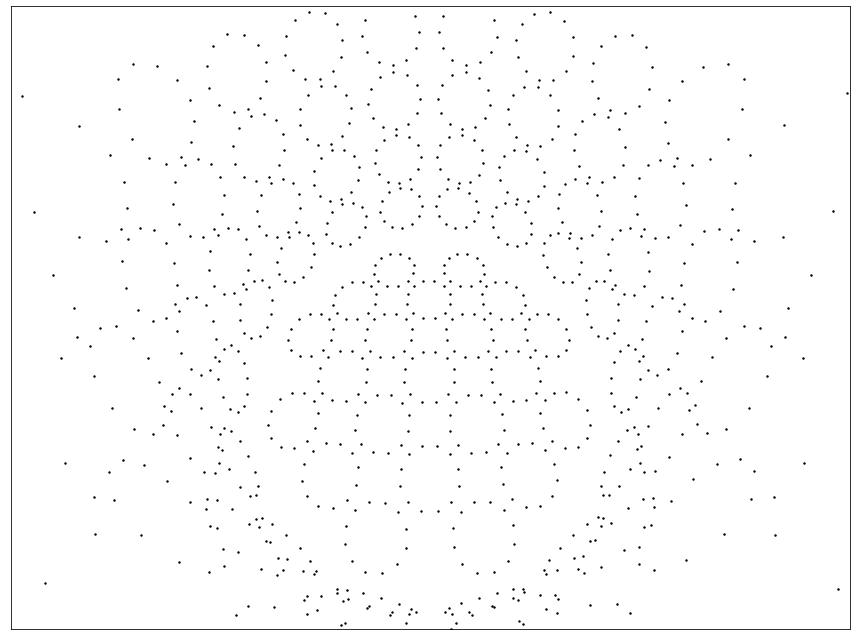

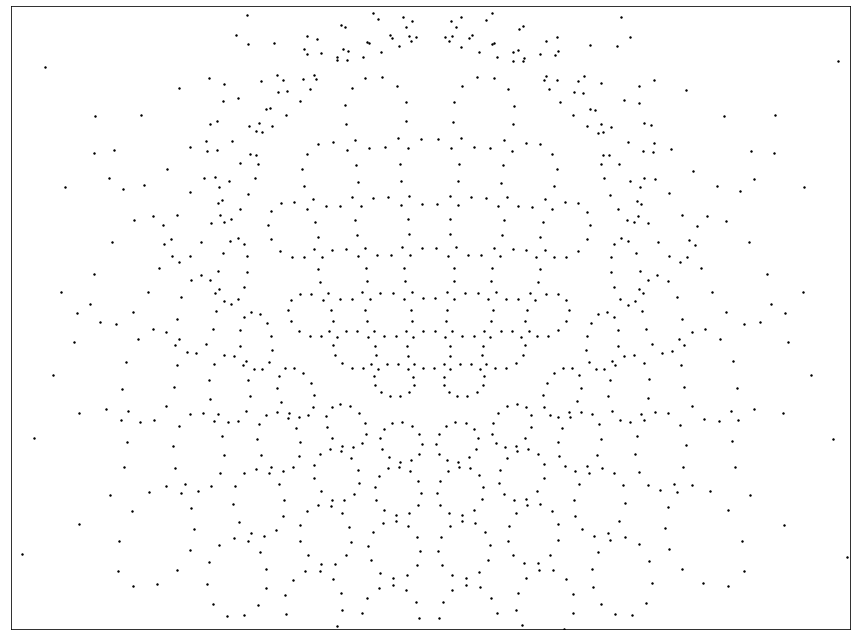

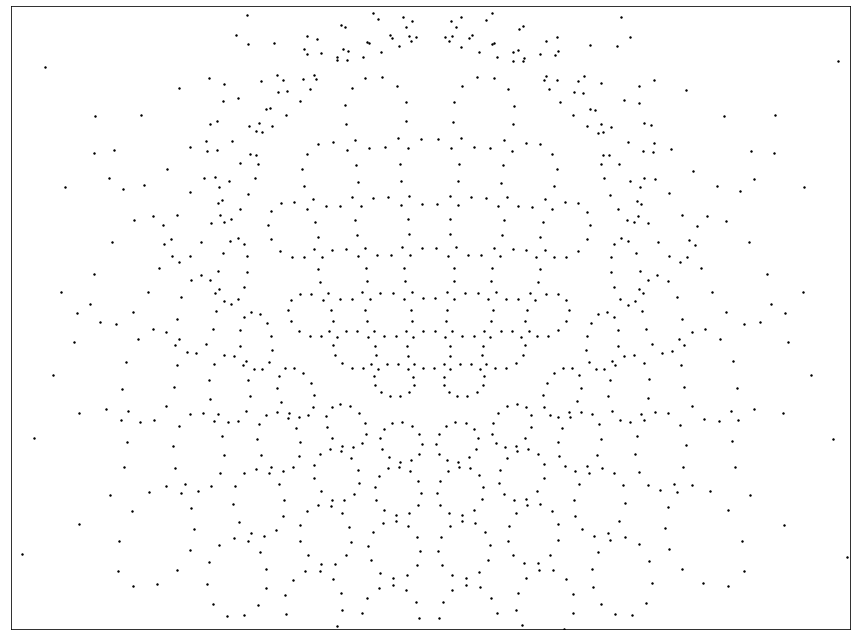

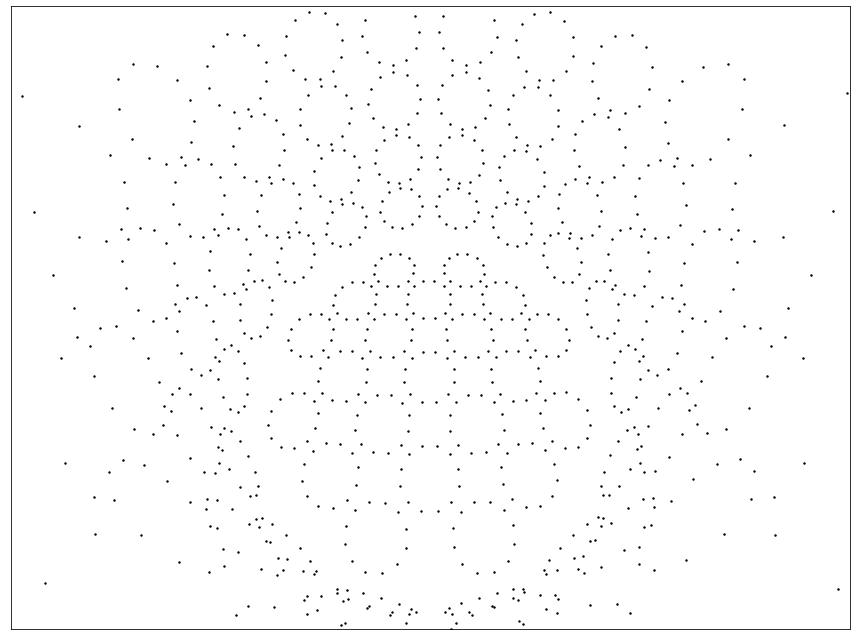

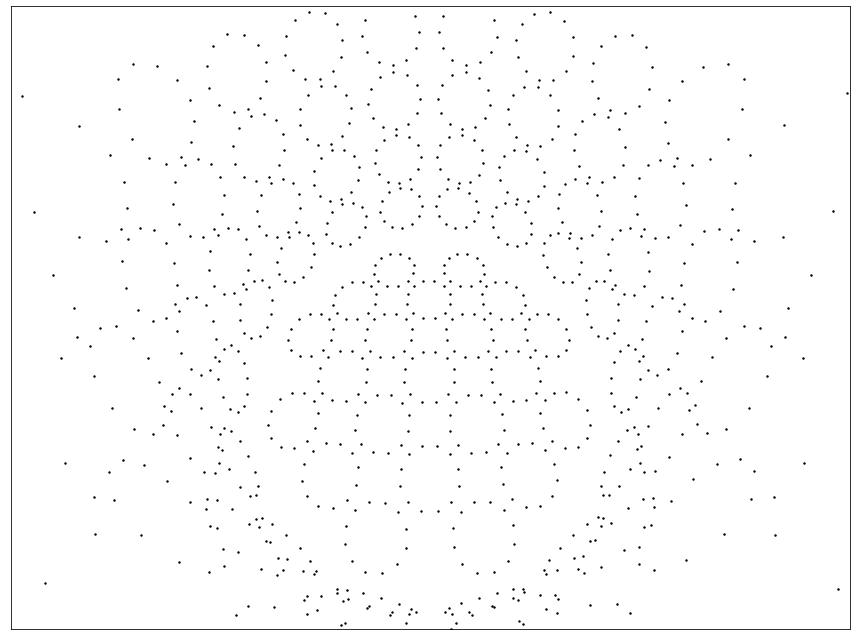

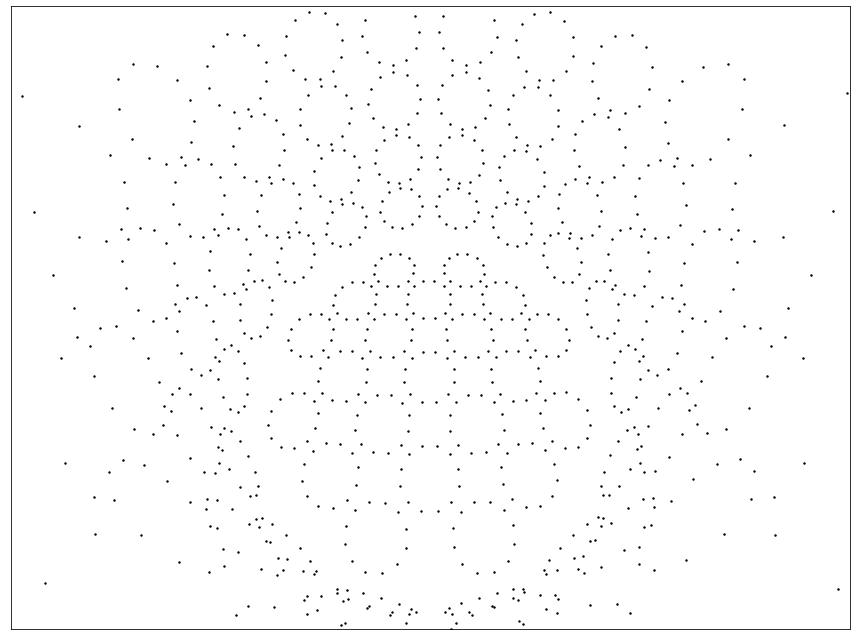

In [25]:
image_feature_locations = simulator.get_image_feature_locations(area_restrict = image_area, min_feature_count = 2)
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
feature_counts_counts = Counter(feature_counts.values())
print("Total number of features: ", len(led_positions))
print("Number of features in more than one image: ", sum(feature_counts_counts.values()))
print("Feature in image counts:", feature_counts_counts)
simulator.show_images(image_feature_locations, area=image_area)

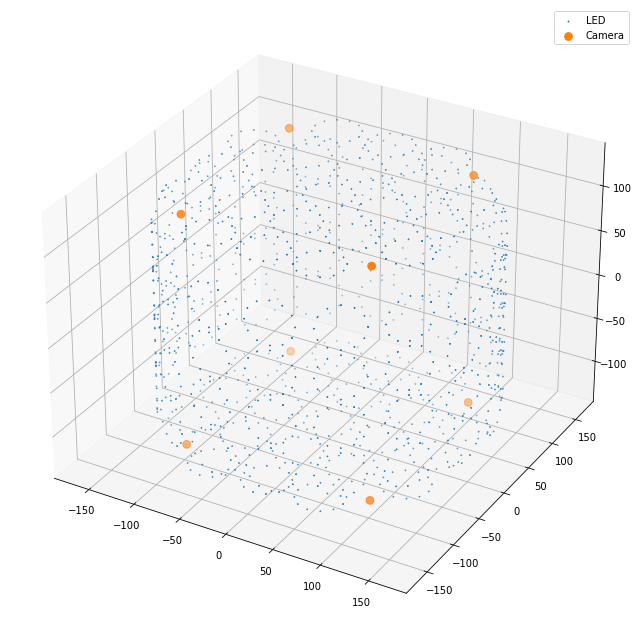

In [26]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
plot_geometry(led_positions, camera_positions)

=== Gaussian errors on feature image locations: 1.0 ===
8 images with total of  1272 features
image 0 reprojection errors:    average:22.278437936550752   max: 400.25971627794144
image 1 reprojection errors:    average:22.03190600363691   max: 272.0990808673007
image 2 reprojection errors:    average:21.63574971852651   max: 326.8181215993555
image 3 reprojection errors:    average:21.69301256883475   max: 179.0624228021027
image 4 reprojection errors:    average:22.60648374913264   max: 329.51644216617495
image 5 reprojection errors:    average:21.961239923829332   max: 381.0160429231665
image 6 reprojection errors:    average:22.05561616144285   max: 251.00725103960175
image 7 reprojection errors:    average:21.378856500094034   max: 239.22639530129806
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.2495e+06                                    6.41e+06    
       1              2         9.5121e+03      3.24e

       8              9         3.4627e+05      4.37e+00       1.76e-02       1.64e+02    
       9             10         3.4626e+05      3.59e+00       2.47e-02       3.25e+02    
      10             11         3.4626e+05      3.03e+00       1.33e-02       1.39e+02    
      11             12         3.4626e+05      2.96e+00       2.19e-02       3.15e+02    
      12             13         3.4625e+05      2.92e+00       1.29e-02       1.35e+02    
      13             14         3.4625e+05      2.87e+00       2.14e-02       3.00e+02    
      14             15         3.4625e+05      2.80e+00       1.25e-02       1.37e+02    
      15             16         3.4624e+05      2.50e+00       1.88e-02       2.63e+02    
      16             17         3.4624e+05      2.52e+00       1.17e-02       1.74e+02    
      17             18         3.4624e+05      2.12e+00       1.53e-02       2.95e+02    
      18             19         3.4624e+05      2.26e+00       1.11e-02       2.24e+02    

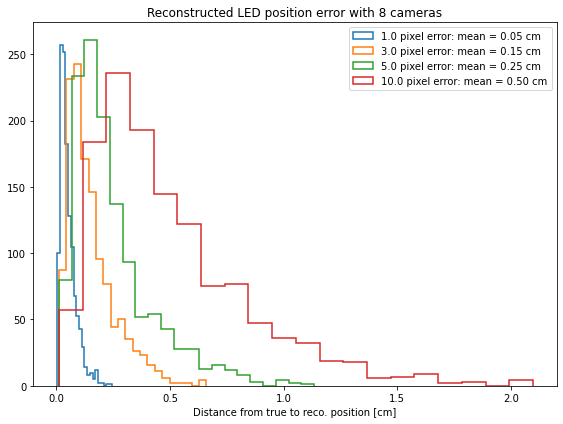

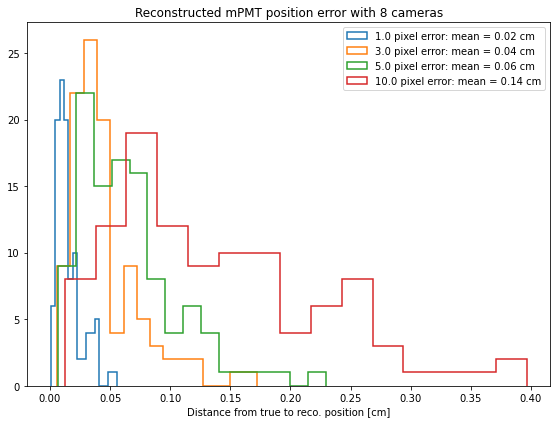

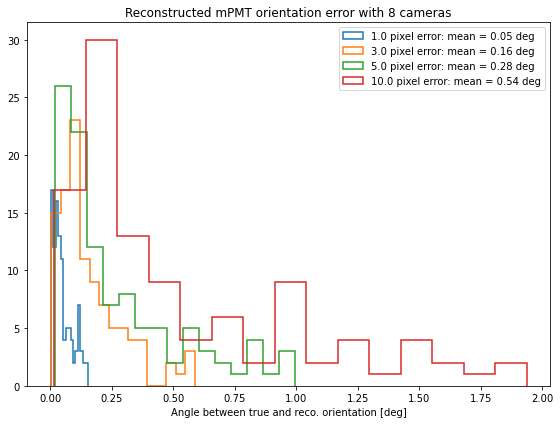

In [27]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_8a = {}
centre_errors_8a = {}
orientation_errors_8a = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_8a = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_8a, smeared_feature_locations, focal_length, principle_point, radial_distortion)    
    reco_led_positions, position_errors_8a[pixel_error] = run_led_fit(fitter, led_positions_8a)
    centre_errors_8a[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_8a[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_8a[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_8a[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_8a[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_8a[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

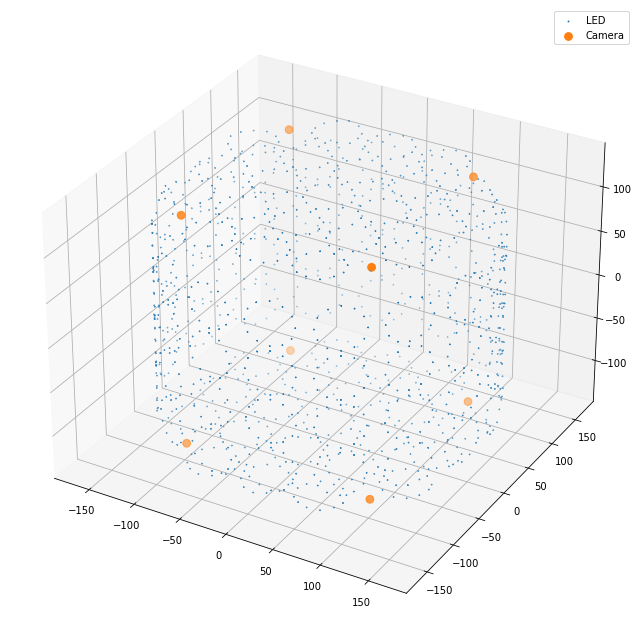

In [28]:
reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_led_positions)

reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

plot_reconstruction(reco_transformed, cam_positions_transformed)

## 1% errors on parameters

### 1% error on focal length

In [49]:
param_error = 0.01
focal_length2 = focal_length*(1+param_error) # np.random.normal(focal_length, focal_length*param_error)
principle_point2 = principle_point#*(1+param_error) # np.random.normal(principle_point, principle_point*param_error)
radial_distortion2 = radial_distortion#*(1+param_error) # np.random.normal(radial_distortion, np.abs(radial_distortion)*param_error)

=== Gaussian errors on feature image locations: 1.0 ===
8 images with total of  1272 features
image 0 reprojection errors:    average:24.608593769035938   max: 611.3982243689502
image 1 reprojection errors:    average:25.22544332715471   max: 495.0297124939188
image 2 reprojection errors:    average:25.22786374138796   max: 513.9932784446748
image 3 reprojection errors:    average:24.03060745916949   max: 330.44036295317017
image 4 reprojection errors:    average:26.61895385961153   max: 419.4486744329757
image 5 reprojection errors:    average:29.342917584909316   max: 652.9085253560725
image 6 reprojection errors:    average:30.642017945278138   max: 365.20604851963196
image 7 reprojection errors:    average:25.726036338857043   max: 525.6435080715578
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9460e+06                                    1.97e+07    
       1              2         2.6607e+05      5.68e+

      34             35         2.2044e+05      1.70e+00       8.97e-03       1.97e+02    
      35             36         2.2044e+05      5.56e-01       4.32e-03       1.62e+02    
`xtol` termination condition is satisfied.
Function evaluations 36, initial cost 5.5667e+06, final cost 2.2044e+05, first-order optimality 1.62e+02.
mean reprojection error: 6.0453435047595665
max reprojection error: 30.502529209647467
mean reconstruction error: 0.6581047590467232
max reconstruction error: 1.8248533765613457
=== Gaussian errors on feature image locations: 5.0 ===
8 images with total of  1272 features
image 0 reprojection errors:    average:25.978179118175426   max: 285.88640917083137
image 1 reprojection errors:    average:25.857737915382835   max: 416.97789242157654
image 2 reprojection errors:    average:27.349217654377938   max: 466.2649834412381
image 3 reprojection errors:    average:25.182904882084554   max: 305.4152031471961
image 4 reprojection errors:    average:25.691279087423936 

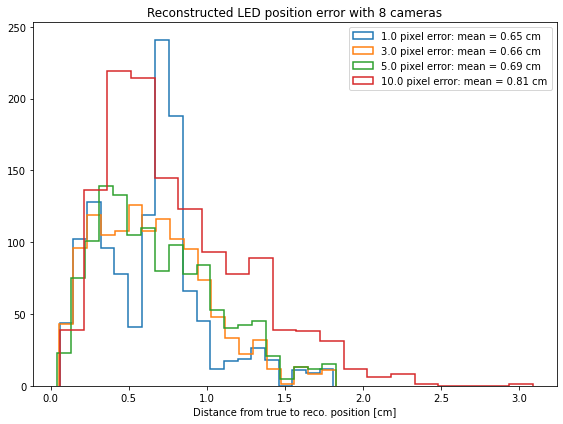

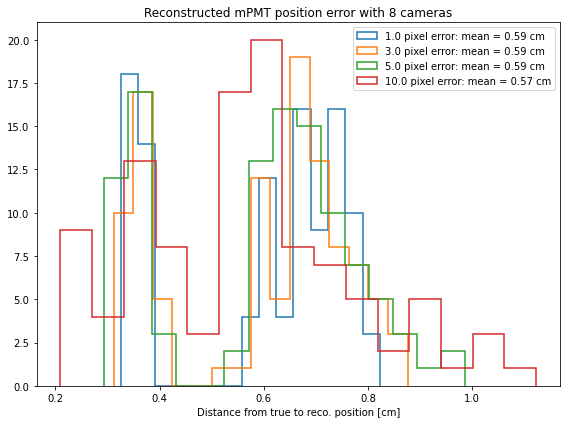

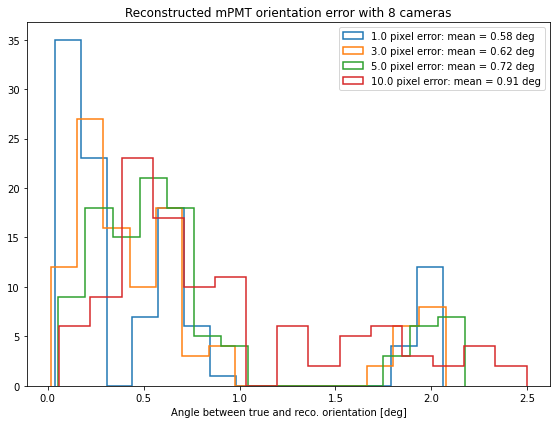

In [50]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_8a = {}
centre_errors_8a = {}
orientation_errors_8a = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_8a = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_8a, smeared_feature_locations, focal_length2, principle_point2, radial_distortion2)    
    reco_led_positions, position_errors_8a[pixel_error] = run_led_fit(fitter, led_positions_8a)
    centre_errors_8a[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_8a[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_8a[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_8a[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_8a[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_8a[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

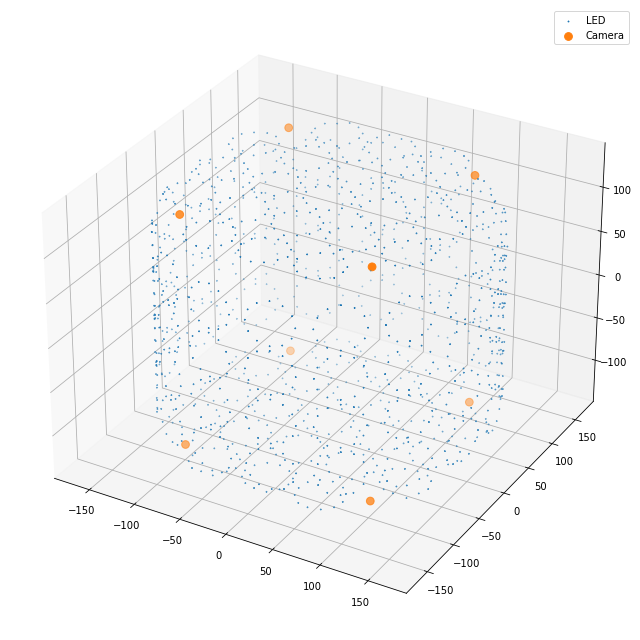

In [51]:
reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_led_positions)

reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

plot_reconstruction(reco_transformed, cam_positions_transformed)

### 1% change to priciple point

In [55]:
param_error = 0.01
focal_length2 = focal_length#*(1+param_error) # np.random.normal(focal_length, focal_length*param_error)
principle_point2 = principle_point*(1+param_error) # np.random.normal(principle_point, principle_point*param_error)
radial_distortion2 = radial_distortion#*(1+param_error) # np.random.normal(radial_distortion, np.abs(radial_distortion)*param_error)

=== Gaussian errors on feature image locations: 1.0 ===
8 images with total of  1272 features
image 0 reprojection errors:    average:25.715267466530307   max: 389.5702996306772
image 1 reprojection errors:    average:26.07413033212313   max: 345.1051858736134
image 2 reprojection errors:    average:26.77905825498852   max: 261.0804710645033
image 3 reprojection errors:    average:31.2411256416308   max: 637.4945383848378
image 4 reprojection errors:    average:27.790161271191213   max: 308.06463497960056
image 5 reprojection errors:    average:26.06536287967614   max: 397.9434694791789
image 6 reprojection errors:    average:26.024265460862825   max: 407.1200419772698
image 7 reprojection errors:    average:25.761487361273964   max: 465.7899440893637
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.3105e+06                                    2.21e+07    
       1              2         5.9727e+05      4.71e+06

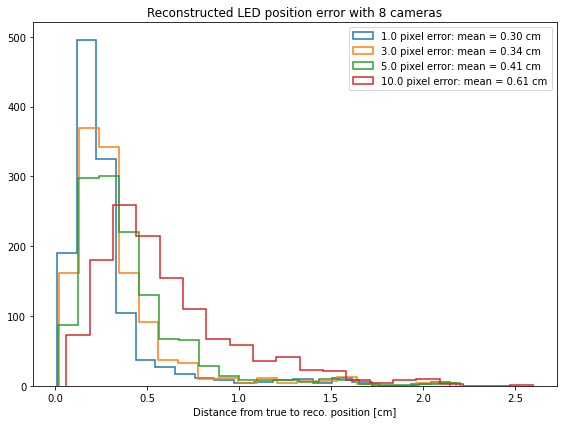

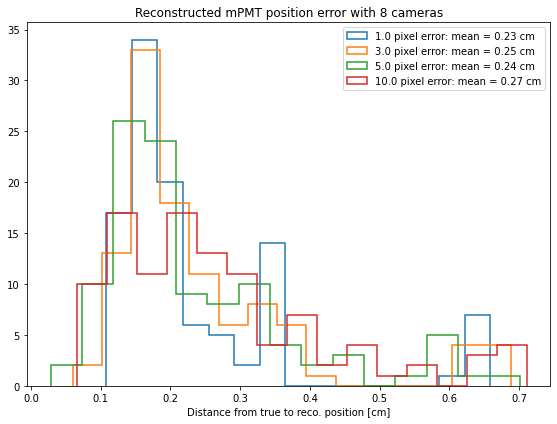

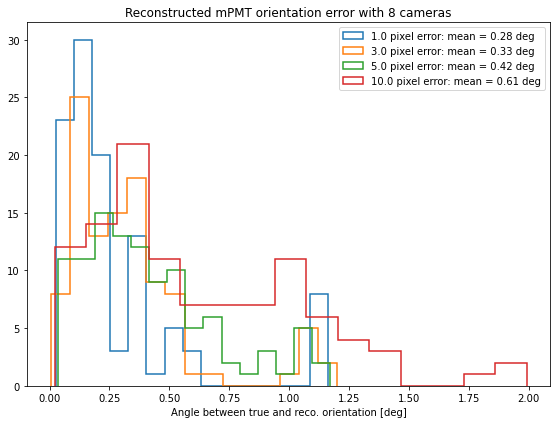

In [56]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_8a = {}
centre_errors_8a = {}
orientation_errors_8a = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_8a = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_8a, smeared_feature_locations, focal_length2, principle_point2, radial_distortion2)    
    reco_led_positions, position_errors_8a[pixel_error] = run_led_fit(fitter, led_positions_8a)
    centre_errors_8a[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_8a[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_8a[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_8a[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_8a[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_8a[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

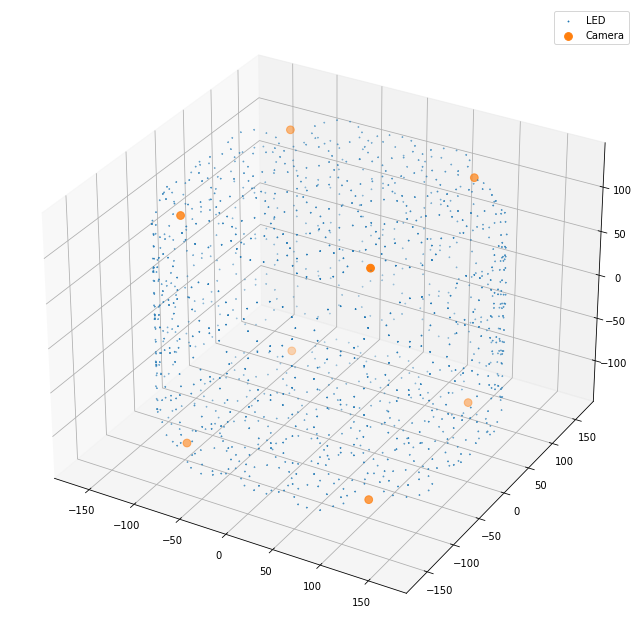

In [57]:
reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_led_positions)

reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

plot_reconstruction(reco_transformed, cam_positions_transformed)

### 5% error on radial distortion

In [61]:
param_error = 0.05
focal_length2 = focal_length#*(1+param_error) # np.random.normal(focal_length, focal_length*param_error)
principle_point2 = principle_point#*(1+param_error) # np.random.normal(principle_point, principle_point*param_error)
radial_distortion2 = radial_distortion*(1+param_error) # np.random.normal(radial_distortion, np.abs(radial_distortion)*param_error)

=== Gaussian errors on feature image locations: 1.0 ===
8 images with total of  1272 features
image 0 reprojection errors:    average:26.511384732825423   max: 378.01580465147475
image 1 reprojection errors:    average:24.263343179091372   max: 568.7827890898637
image 2 reprojection errors:    average:24.92150383778915   max: 721.4168575965579
image 3 reprojection errors:    average:23.925002124319143   max: 489.6881011422849
image 4 reprojection errors:    average:27.368396161178776   max: 517.734072939231
image 5 reprojection errors:    average:24.735638947862267   max: 684.4504984363251
image 6 reprojection errors:    average:26.946181481137916   max: 542.0411179302149
image 7 reprojection errors:    average:25.43422923307925   max: 712.6878967480803
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.8969e+06                                    2.71e+07    
       1              2         2.0056e+05      5.70e+

       5              6         2.5839e+05      1.88e+01       9.56e-02       3.57e+03    
       6              7         2.5838e+05      1.10e+01       4.19e-02       1.54e+03    
       7              8         2.5837e+05      5.70e+00       3.12e-02       1.03e+03    
       8              9         2.5837e+05      3.96e+00       1.81e-02       7.32e+02    
       9             10         2.5836e+05      3.78e+00       2.45e-02       6.17e+02    
      10             11         2.5836e+05      3.52e+00       1.64e-02       6.07e+02    
      11             12         2.5836e+05      3.59e+00       2.45e-02       4.56e+02    
      12             13         2.5835e+05      2.93e+00       1.29e-02       4.64e+02    
      13             14         2.5835e+05      2.96e+00       2.24e-02       3.68e+02    
      14             15         2.5835e+05      3.08e+00       1.39e-02       4.78e+02    
      15             16         2.5834e+05      2.43e+00       1.77e-02       2.46e+02    

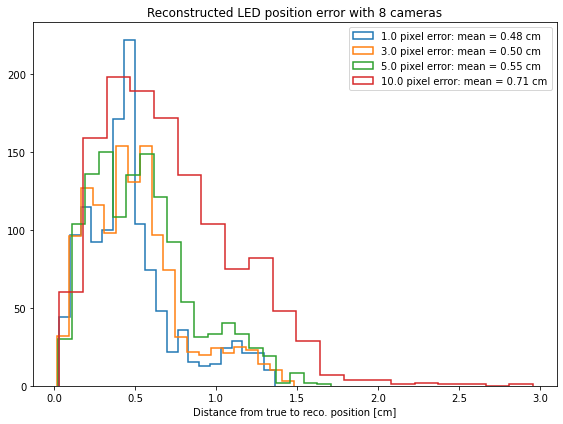

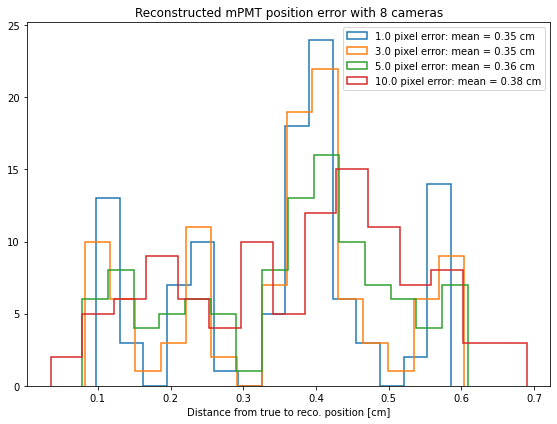

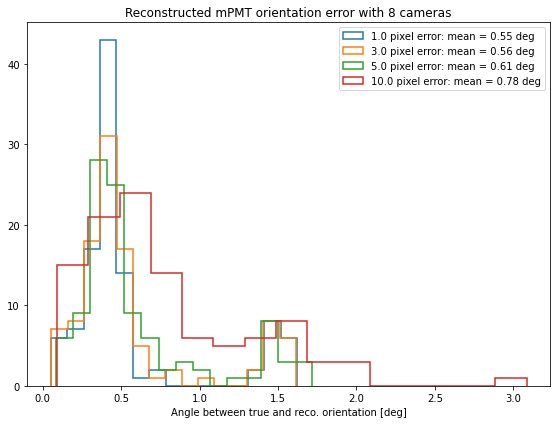

In [62]:
fig_led_pos, ax_led_pos = make_fig("Reconstructed LED position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_pos, ax_mpmt_pos = make_fig("Reconstructed mPMT position error with {} cameras".format(camera_count), "Distance from true to reco. position [cm]")
fig_mpmt_ang, ax_mpmt_ang = make_fig("Reconstructed mPMT orientation error with {} cameras".format(camera_count), "Angle between true and reco. orientation [deg]")
position_errors_8a = {}
centre_errors_8a = {}
orientation_errors_8a = {}
for pixel_error in [1.0, 3.0, 5.0, 10.0]:
    print("=== Gaussian errors on feature image locations:", pixel_error, "===")
    smeared_feature_locations = simulator.get_image_feature_locations(area_restrict=image_area, min_feature_count=2, pixel_error=pixel_error)
    led_positions_8a = {k: v for k, v in led_positions.items() if np.any([k in i.keys() for i in smeared_feature_locations.values()])}
    fitter = setup_led_simulation(led_positions_8a, smeared_feature_locations, focal_length2, principle_point2, radial_distortion2)    
    reco_led_positions, position_errors_8a[pixel_error] = run_led_fit(fitter, led_positions_8a)
    centre_errors_8a[pixel_error] = get_mpmt_centre_errors(reco_led_positions, mpmt_locations, led_count)
    orientation_errors_8a[pixel_error] = get_mpmt_orientation_errors(reco_led_positions, mpmt_orientations, led_count)
    ax_led_pos.hist(position_errors_8a[pixel_error], bins=20, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, position_errors_8a[pixel_error].mean()))
    ax_mpmt_pos.hist(centre_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} cm".format(pixel_error, centre_errors_8a[pixel_error].mean()))
    ax_mpmt_ang.hist(orientation_errors_8a[pixel_error], bins=15, histtype='step', lw=1.5, label="{} pixel error: mean = {:.2f} deg".format(pixel_error, orientation_errors_8a[pixel_error].mean()))
ax_led_pos.legend(loc='upper right')
ax_mpmt_pos.legend(loc='upper right')
ax_mpmt_ang.legend(loc='upper right')

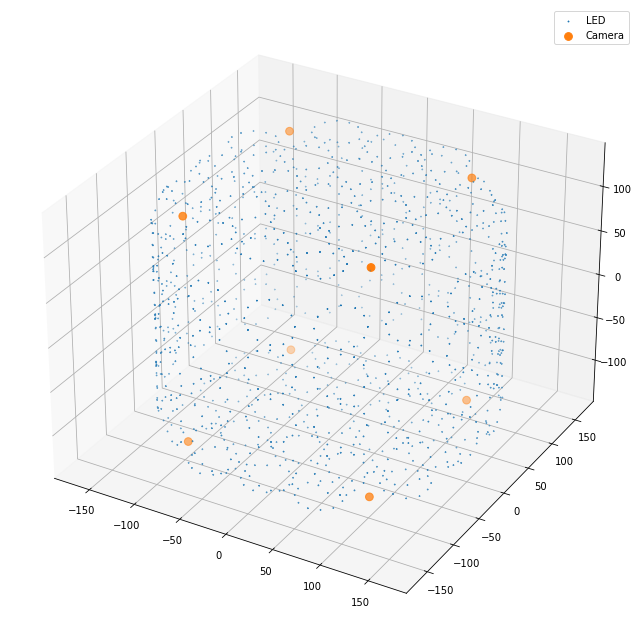

In [63]:
reco_errors, reco_transformed, scale, R, translation, _ = fit.kabsch_errors(led_positions, reco_led_positions)

reco_cam_orientations, reco_cam_positions = fit.camera_world_poses(fitter.camera_rotations, fitter.camera_translations)
cam_orientations_transformed = np.matmul(R, reco_cam_orientations)
cam_positions_translated = reco_cam_positions - translation
cam_positions_transformed = scale*R.dot(cam_positions_translated.transpose()).transpose()

plot_reconstruction(reco_transformed, cam_positions_transformed)